
# Productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta,date
%matplotlib inline

import timeit

import warnings

plt.style.use('seaborn-white')

In [2]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")

# Función Carga de BD

In [3]:
def carga_bd():
    
    global mx_bd
    
    tic=timeit.default_timer()
    
    mx_bd=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_bd.csv',
                          usecols=['fecha',
                                  'pozo',
                                  'aceite_Mbd',
                                  'gas_asociado_MMpcd',
                                  'gas_no_asociado_MMpcd',
                                  'condensado_Mbd',
                                  'agua_Mbd',
                                  'estado actual',
                                  'profundidad_total',
                                  'profundidad_vertical',
                                  'trayectoria', 
                                  'ano_perforacion',
                                  'hidrocarburo',
                                  'clasificacion',
                                  'disponible',
                                  'campo',
                                  'cuenca', 
                                  'entidad',  
                                  'ubicacion',
                                  'asignacion'],
                             low_memory=False)
    
    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

In [4]:
carga_bd()

'Tiempo de procesamiento: 35.9201008 segundos'

# Función Productividad de pozos

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta,date
%matplotlib inline

import timeit
import warnings

plt.style.use('seaborn-white')

pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")


def productividad(hidrocarburo,baja,media,alta,fit):
    
    global unique_well_list
    global data_pozos
    global resultados
    global gasto
    global perfil
    global df
    global estadistica
    global tipo1
    global tipo2
    global tipo3
    global Qo
    global base
    
    tic=timeit.default_timer()
    
    
#############      ESTADISTICA DE POZOS   ####### 
    
    #input de campo de analisis
    def campo_analisis():
        
        global campo
        global input_campo
        global intervalos
    
        #Input de campo
        input_campo = input("Nombre de campo: ")
        intervalos = 3

        seleccion=mx_bd.pozo.str.contains(str(input_campo))
        campo=mx_bd.loc[seleccion]

        unique_well_list=pd.unique(campo['pozo'])

        display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)))

        return campo 

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
 
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):

        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot resultados
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    resultados=pd.DataFrame()
    resumen=pd.DataFrame()
    gasto=pd.DataFrame()
    Qi=pd.DataFrame()
    base=pd.DataFrame()
    fit=pd.DataFrame()
    Qo=pd.DataFrame()
    
    def analisis_dca():
    #Entrada de campo de análisis
    campo_analisis()
    data_pozos=campo
    
    #Limpieza de datos y formato de fecha
    data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
    
    #hidrocarburo de análisis
    hydrocarbon=str(hidrocarburo)
    
    #Remove all rows with null values in the desired time series column
    data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hydrocarbon)
    
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(data_pozos.pozo))
    
    #Get the earliest RecordDate for each Well
    data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                    calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2019-12-01')]
    
    #Loop para realizar el DCA en cada pozo del campo
    for pozo in unique_well_list:
        
        #Subset el data frame del campo por pozo
        serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
        
        #Calculo de declinacion porcentual
        serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)
        
        #Cálculo de la máxima producción inicial
        qi=get_max_initial_production(serie_produccion, 500, hydrocarbon, 'fecha')
        
        #Columna de mes de producción
        serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()

        #Ajuste Hiperbolico
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, serie_produccion['mes'], 
                                     serie_produccion[hydrocarbon],bounds=(0, [qi,1,50]))
        #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
       
        #Ajuste Harmonico
        popt_harm, pcov_harm=curve_fit(harmonic_equation, serie_produccion['mes'], 
                                     serie_produccion[hydrocarbon],bounds=(0, [qi,50]))
        #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))

        #Resultados de funcion Hiperbolica
        serie_produccion.loc[:,'hiperbolica']=hyperbolic_equation(serie_produccion['mes'], 
                                  *popt_hyp)
        #Resultados de funcion Harmonica
        serie_produccion.loc[:,'harmonica']=harmonic_equation(serie_produccion['mes'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_hyp))
        
        seleccion_base=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
        
        fit=[[pozo,
              popt_hyp[0],
              popt_hyp[1],
              popt_hyp[2],
              float(seleccion_base[hidrocarburo]),
              int(seleccion_base.mes),
              perr[0],
              perr[1]]]
    
        
        Qi=[[pozo,qi,popt_hyp[1],popt_hyp[2]]]
    

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,'harmonica','hiperbolica']
        x_variable='mes'
        
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        
        #Plot the data to visualize the equation fit
        #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)

        base=base.append(fit,sort=False)
        resultados=resultados.append(serie_produccion,sort=False)
        gasto=gasto.append(Qi,sort=True)
    
    base=base.rename(columns={0:'pozo',
                              1:'Qi',
                              2:'b',
                              3:'di',
                              4: hidrocarburo,
                              5:'mes',
                              6:'error_Qo_hiperbolica',
                              7:'error_di_hiperbolica'})
    
    estadistica=resultados.describe()
            
    perfil_base=pd.DataFrame()
    df=pd.DataFrame()
    periodo=np.arange(start=1,stop=501,step=1)
    df['periodo']=periodo  
        
    #for x in base.pozo:
        
     #   perfil_base['pozo']=base.pozo
        
    for y in df:

        perfil_base['pozo']=base.pozo
        perfil_base['mes']=df.periodo
        perfil_base['Qo_base']=base[hidrocarburo]/((1.0+base['b']*base['di']*df.periodo**(1.0/base['b'])))

        Qo = Qo.append(perfil_base,sort=False)

    
    #display(Qo)
    #resultados.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')

    gasto=gasto.rename(columns={0:'Pozo',1:'Qi',2:'b',3:'di'})
    gasto.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto.csv')
        
    display(base)
    estadistica=resultados.describe()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

In [40]:
productividad('aceite_Mbd',0.30,0.50,0.80)

Nombre de campo: SIHIL


'Número de pozos en SIHIL: 28'

ValueError: cannot reindex from a duplicate axis

In [ ]:
display(Qo)

In [21]:
oil=resultados[['pozo','aceite_Mbd','mes']]

df2=oil.groupby('mes').mean().reset_index()

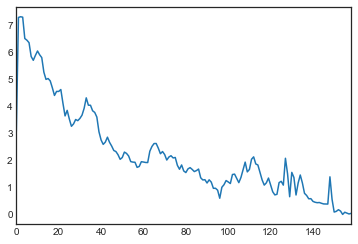

In [22]:
df2.aceite_Mbd.plot()

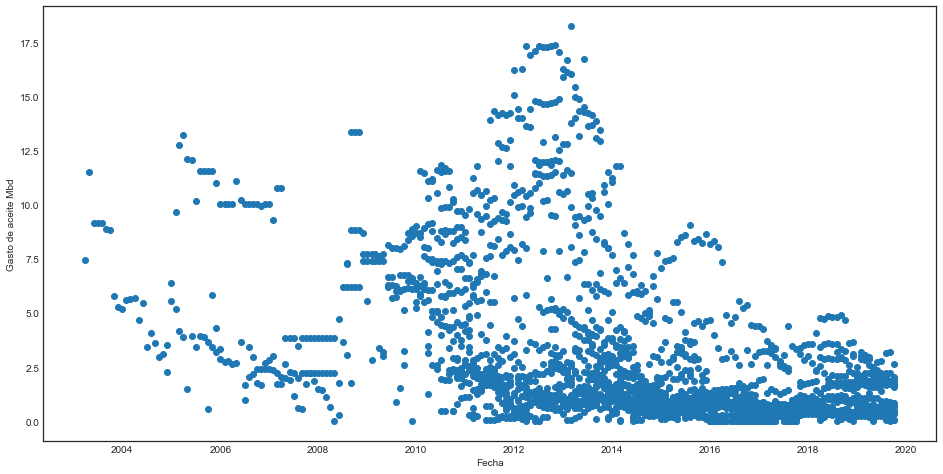

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(campo.fecha,campo.aceite_Mbd)
ax.set_xlabel('Fecha')
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()